In [4]:
import numpy as np
from scipy import linalg
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
from scipy import optimize

from sklearn.neighbors import NearestNeighbors, kneighbors_graph
#import utils_local as utils

from pymanopt import Problem
from pymanopt.manifolds import Euclidean, Rotations
from pymanopt.solvers import TrustRegions, SteepestDescent, ConjugateGradient

class GSE():

    """Grassmann-Stiefel Eigenmaps (GSE)
    Parameters
    ----------
    n_components : integer
        Number of coordinates for the manifold.
    n_neighbors : integer
        Number of k nearest neighbors, if 'knn' neighborhood_method is selected.
    sigma : float
        \sigma of Gaussian kernel, while computing points' similarity.
    solver : string ['base'|'eig'|'stiefel']
        Solver for tangent spaces alignment subproblem.
        'base' : contraction mapping,
        'eig' : generalized eigenvalue problem,
        'stiefel' : optimization on orthogonal group.
    eps : float
        \eps of open ball of neighborhood, if 'eps_ball'
        neighborhood_method is selected
    max_iter : integer
        Maximum number of iterations, if 'base' solver is selected
    tol : float
        Convergence tolerance, if 'base' solver is selected
    neighborhood_method : string ['knn', 'eps_ball']
        Method for selecting neighborhoods of points.
        'knn' : k nearest neighbors
        'eps_ball' : epsilon-ball with radius \eps
    neighbors_algorithm : string ['auto'|'brute'|'kd_tree'|'ball_tree']
        Algorithm to use for nearest neighbors search,
        passed to neighbors.NearestNeighbors instance.
    metric : string, precomputed or callable
        Metric for finding nearest neighbors.
    weighted_pca : bool
        Whether to perform weighted version of PCA,
        while estimating tangent spaces.
    weighted_ls: bool
        Whether to perform weighted version of least squares problem,
        while computing embedding.
    oriented: bool
        Whether to orient tangent spaces on manifold.
    n_jobs : int, optional (default = 1)
        The number of parallel jobs to run.
        If ``-1``, then the number of jobs is set to the number of CPU cores.
     """
    
    def __init__(self, n_components=2, n_neighbors=5, eps=None, sigma=1.0, solver="base", max_iter=100, tol=1e-6, neighborhood_method="knn", neighbors_algorithm="auto", metric="euclidean", weighted_pca=True, weighted_ls=True, oriented=True, n_jobs=1):
        self.n_components = n_components 
        self.n_neighbors = n_neighbors
        self.eps = eps
        self.sigma = sigma
        self.solver = solver
        self.max_iter = max_iter
        self.tol = tol
        self.neighborhood_method = neighborhood_method
        self.neighbors_algorithm = neighbors_algorithm
        self.metric = metric
        self.weighted_pca = weighted_pca
        self.weighted_ls = weighted_ls
        self.oriented = oriented
        self.n_jobs = n_jobs

        self.X = None
        self.H = None
        self.Q = None
        self.G = None
        self.h = None

    def _build_graph(self, X):
        """Construction of connectivity graph G"""
        
        neighbors = NearestNeighbors(algorithm=self.neighbors_algorithm, metric=self.metric, n_jobs=self.n_jobs).fit(X)

        if self.neighborhood_method == "knn":
            # TODO: assert n_neighbors < number of points
            G = neighbors.kneighbors_graph(n_neighbors=self.n_neighbors, mode="distance") # к ближних соседей для одного, для другого этот один может не быть в к ближних
        elif self.neighborhood_method == "eps_ball":
            # TODO: assert eps is not None
            G = neighbors.radius_neighbors_graph(radius=self.eps, mode="distance")
        else:
            raise ValueError("Unrecognized method of neighborhood selection='{0}'""".format(self.neighborhood_method))
        
        G_sym  = csr_matrix.maximum(G, G.T.tocsr())
        
        G_sym.data = self._kernel(G_sym.data, sigma=self.sigma)
        G.data = self._kernel(G.data, sigma=self.sigma)
        
        return G_sym

    def _estimate_Q(self, X, G, weighted_pca=True, oriented=True):
        """Estimation of tangent space Q(X_i) at each point X_i."""

        (N, D), d = X.shape, self.n_components
        
        Q = np.empty((N, D, d))

        indptr = G.indptr
        indices = G.indices

        K = G.data
        
        for i in range(N):
            U_idx = indices[indptr[i]:indptr[i+1]] # массив , где в i-ой строке лежат номера с кем связан i-ый элемент, что делать если с элементом никто не свзяан?
            U_i = X[U_idx, :] - X[i] # смещение в 0

            if (weighted_pca==True):
                U_i = G.data[indptr[i]:indptr[i+1]].reshape(-1, 1) * U_i
    
            _, _, V = np.linalg.svd(U_i.T.dot(U_i)) # теория для PCA

            Q[i] = V[:d, :].T 
            
        if oriented==True:
            Q = self._orient_Q(Q, G)

        return Q
    
    def get_order(self, graph):
        """Orientation of tangent bundle Q."""
        N = graph.shape[0]
        nnz = graph.nnz
        indptr = graph.indptr
        indices = graph.indices
        data = graph.data
        indptr_enlarged = np.empty(N+1, dtype=np.int32)
        indices_enlarged = np.empty(nnz+N, dtype=np.int32)
        data_enlarged = np.empty(nnz+N)
        for i in range(N):
            delta = indptr[i+1] - indptr[i]
            indices_local = indices[indptr[i]:indptr[i+1]]
            data_local = data[indptr[i]:indptr[i+1]]
            order_local = np.argsort(data_local)

            shift = indptr[i] + i
            indices_enlarged[shift:shift+delta] = indices_local[order_local]
            indices_enlarged[shift+delta] = -1
            data_enlarged[shift:shift+delta] = data_local[order_local]
            data_enlarged[shift+delta] = np.inf
            indptr_enlarged[i] = shift
        indptr_enlarged[N] = indptr[N] + N

        points_oriented = np.empty(N, dtype=np.int32)
        points_oriented[0] = 0
        points_order = np.empty(N, dtype=np.int32)
        points_order[0] = 0
        points_close = np.empty(N, dtype=np.int32)
        points_close[0] = -1
        points_used = np.zeros(N, dtype=np.bool_)
        points_used[0] = True
        for i in range(1, N):
            points_local = points_oriented[:i]
            min_distances = np.empty_like(points_local, dtype=np.float64)
            for p, point in enumerate(points_local):
                min_distances[p] = data_enlarged[indptr_enlarged[point]]
            point_min = np.argmin(min_distances)
            point_close = points_local[point_min]
            point_selected = indices_enlarged[indptr_enlarged[point_close]]

            while points_used[point_selected] and point_selected >= 0:
                indptr_enlarged[point_close] += 1
                min_distances[point_min] = data_enlarged[indptr_enlarged[point_close]]
                point_min = np.argmin(min_distances)
                point_close = points_local[point_min]
                point_selected = indices_enlarged[indptr_enlarged[point_close]]

            if point_selected >= 0:
                indptr_enlarged[point_close] += 1
            elif point_selected == -1:
                print("Another component is found")
                point_close = 0
                for p, point in enumerate(points_local):
                    if p != point:
                        point_selected = p
                        break
                if point_selected == -1:
                    point_selected = i
            else:
                print("Error in function get_order")

            k = np.searchsorted(points_local, point_selected)
            points_oriented[k+1:i+1] = points_oriented[k:i]
            points_oriented[k] = point_selected
            points_order[i] = point_selected
            points_close[i] = point_close
            points_used[point_selected] = True

        return points_order, points_close

    def _orient_Q(self, Q, G):
        """Orientation of tangent bundle Q."""
        points_order, points_close = self.get_order(G)
        #N, p, q = Q.shape
        Q_oriented = np.empty_like(Q)
        #Q_oriented = np.nan
        #points_order, points_close = get_order(graph)
        Q_oriented[0, :, :] = Q[0, :, :]
        for point_selected, point_close in zip(points_order[1:], points_close[1:]):
            if np.linalg.slogdet(Q[point_selected, :, :].T.dot(Q_oriented[point_close, :, :]))[0] > 0:
                Q_oriented[point_selected, :, :] = Q[point_selected, :, :]
            else:
                Q_oriented[point_selected, :, 0] = Q[point_selected, :, 1]
                Q_oriented[point_selected, :, 1] = Q[point_selected, :, 0]
                Q_oriented[point_selected, :, 2:] = Q[point_selected, :, 2:]
        return Q_oriented

    def _align_H(self, Q, G):
        """Dispatch to the right submethod for alignment of tangent bundle H."""

        if self.solver == 'base':
            return self._align_H_base(Q, G)
        else:
            raise ValueError("Unrecognized solver='{0}'""".format(self.solver))

    def _align_H_base(self, Q, G):
        """Tangent vector field alignment via contraction mappings."""
        
        N, D, d = Q.shape

        indptr = G.indptr
        indices = G.indices

        K = G.data
        
        P = np.empty((N, D, D))
        for i in range(N):
            P[i] = Q[i].dot(Q[i].T)
        
        H = np.array(Q)
        
        I_d_diag = np.eye(D)[:, :d]
        
        for k in range(self.max_iter):
            for i in range(N):
                H_local = np.zeros((D, d))
                for index, K_ij in zip(indices[indptr[i]:indptr[i+1]], K[indptr[i]:indptr[i+1]]):
                    H_local[:, :] += K_ij * H[index, :, :]
                
                U, _, V = np.linalg.svd(P[i].dot(H_local))
                H[i, :, :] = U.dot(I_d_diag).dot(V)

        return H
    
    def _embedding(self, X, weighted_ls=True):

        (N, D), d, k = X.shape, self.n_components, self.n_neighbors
        
        indptr = self.G.indptr
        indices = self.G.indices
        
        K = self.G.data

        # build vector x: k * N x D
        x = np.zeros((K.shape[0], D))

        for i in range(X.shape[0]):
            x[indptr[i]:indptr[i+1], :] = X[indices[indptr[i]:indptr[i+1]]] - X[i] # касательное пространство?
                
        x = x.reshape(-1, 1)

        # build matrix A: k * N * D x D * (N-1)
        A = np.zeros((K.shape[0] * D, d * (N-1)))

        for i in range(N):
    
            for idx, (j, K_ij) in enumerate(zip(indices[indptr[i]:indptr[i+1]], K[indptr[i]:indptr[i+1]])):
                
                K_ij = np.sqrt(K_ij)
                
                # i_a, i_a_to: idx*D + (i*k*D), idx*D + (i*k*D+D)
                i_a, i_a_to = idx*D + (indptr[i]*D), idx*D + (indptr[i]*D+D)

                ji_a, ji_a_to = i*d, i*d+d
                jj_a, jj_a_to = j*d, j*d+d
            
                if (i==N-1):
                    # fill line of H_n, n==i
                    A_i = np.tile(K_ij * self.H[i], (1, N-1))
                    A[i_a:i_a_to, 0:d*(N-1)] = A_i
                    
                    # set j-th column to 2H_n
                    A[i_a:i_a_to, jj_a:jj_a_to] = K_ij * 2 * self.H[i]
                    
                elif (j==N-1):
                    # fill line of -H_n, n==j
                    A_i = np.tile(K_ij * -self.H[j], (1, N-1))
                    A[i_a:i_a_to, 0:d*(N-1)] = A_i
                    
                    # set i-th column to 2H_n
                    A[i_a:i_a_to, ji_a:ji_a_to] = K_ij * -2 * self.H[i]
                    
                else:
                    # insert -H_i for i
                    A[i_a:i_a_to, ji_a:ji_a_to] = K_ij * -self.H[i]
                    
                    # insert H_i for j
                    A[i_a:i_a_to, jj_a:jj_a_to] = K_ij * self.H[i]

        # solve linear system (w/ QR factorization)
        Q, R = np.linalg.qr(A)
        z_truncated = linalg.solve_triangular(R, Q.T.dot(x), lower=False).reshape(N-1, -1)
        
        # recover z_n
        z_n = -np.sum(z_truncated, axis=0)
        z = np.vstack((z_truncated, z_n))

        return z
    
    def _embedding_OOS(self, G, Q_x, x):#out-of-sample
        
        N, D, d = self.X.shape[0] + 1, self.H.shape[1], self.n_components
        
        indptr = G.indptr
        indices = G.indices
        K = G.data
        
        kernel_sum = 0.0
        X_sum = np.zeros(D)
        h_sum = np.zeros(d)
        H_sum = np.zeros((D, d))
        
        y_residuals_sum = np.zeros(d)
        
        i = N - 1
        for j, K_ij in zip(indices[indptr[i]:indptr[i+1]], K[indptr[i]:indptr[i+1]]):#почему ядро такое же?

            kernel_sum += K_ij
            X_sum += K_ij * self.X[j]
            h_sum += K_ij * self.h[j]
            H_sum += K_ij * self.H[j]

        h = (h_sum/kernel_sum).T + (np.linalg.inv((Q_x.T).dot(H_sum/kernel_sum)).dot(Q_x.T)).dot((x - X_sum/kernel_sum).T)

        return h.T #out-of-sample

    def _reconstruction(self, y, z):
        
        N, D, d, k = self.H.shape[0], self.H.shape[1], self.n_components, self.n_neighbors
        
        indptr = self.G.indptr
        indices = self.G.indices
        K = self.G.data

        reconstructed_data = []

        for i in range(N):
            
            kernel_sum = 0.0
            G_matrix_sum = np.zeros((D, d))
            X_sum = np.zeros(D)
            y_residuals_sum = np.zeros(d)
            
            Q_rec_point = self.Q[i]
            
            for j, K_ij in zip(indices[indptr[i]:indptr[i+1]], K[indptr[i]:indptr[i+1]]):#почему ядро такое же?
                
                kernel_sum += K_ij
                G_matrix_sum += K_ij * self.H[j]
                X_sum += K_ij * self.X[j]
                y_residuals_sum += K_ij * z[j]
                
            rec_point_projector = Q_rec_point.dot(Q_rec_point.T)
            G_matrix_sum = rec_point_projector.dot(G_matrix_sum) / kernel_sum
            
            g_reconstruction = (X_sum / kernel_sum - G_matrix_sum.dot(y[i] - y_residuals_sum / kernel_sum))
            reconstructed_data.append(g_reconstruction)
            
        reconstructed_data = np.asarray(reconstructed_data)

        return reconstructed_data
        
    def _kernel(self, X, L=None, sigma=1):
        return np.exp(- X ** 2 / (2 * sigma ** 2))

    def _kernel_grassmannian(self, X, Q):

        N, D, d = Q.shape[0], Q.shape[1], self.n_components

        def det2(Q_i, Q_j):
            Q_i = Q_i.reshape(D, d)
            Q_j = Q_j.reshape(D, d)
            return np.linalg.det(Q_i.T.dot(Q_j)) ** 2

        return squareform(pdist(Q.reshape(N, -1), metric=det2))

    def fit(self, X, y=None, embed=True):
        self.X = X
        self.G = self._build_graph(X)
        self.Q = self._estimate_Q(X, self.G, weighted_pca=self.weighted_pca, oriented=self.oriented)

        K_g = self._kernel_grassmannian(X, self.Q)
        K_agg = np.multiply(self.G.A, K_g)
        self.G.data = csr_matrix(K_agg).data

        self.H = self._align_H(self.Q, self.G)

        return self.Q, self.H, self.G

    def transform(self, X):
        self.h = self._embedding(X)

        return self.h
    
    def embedding_OOS(self, X):
    
        N, n = self.X.shape[0], X.shape[0]
        
        embedded_data = []
        reconstructed_data = []
        
        for i in range(n):
            X_i = np.vstack((self.X, X[i]))
            G = self._build_graph(X_i)
            Q = self._estimate_Q(X_i, G, weighted_pca=self.weighted_pca, oriented=self.oriented)
            K_g = self._kernel_grassmannian(X_i, Q)
            K_agg = np.multiply(G.A, K_g)
            G.data = csr_matrix(K_g).data
            
            h = self._embedding_OOS(G, Q[N], X[i])
            embedded_data.append(h)
            
            g = self.reconstruction_OOS(G, h, Q[N])
            reconstructed_data.append(g)
            
        embedded_data = np.asarray(embedded_data)
        reconstructed_data = np.asarray(reconstructed_data)
        
        return embedded_data, reconstructed_data
    
    def reconstruction_OOS(self, G, h, Q_x):
        
        N, D, d, k = self.H.shape[0], self.H.shape[1], self.n_components, self.n_neighbors

        indptr = G.indptr
        indices = G.indices
        K = G.data
            
        kernel_sum = 0.0
        G_matrix_sum = np.zeros((D, d))
        X_sum = np.zeros(D)
        h_sum = np.zeros(d)
            
        Q_rec_point = Q_x
        
        i = N   
        for j, K_ij in zip(indices[indptr[i]:indptr[i+1]], K[indptr[i]:indptr[i+1]]):
                
            kernel_sum += K_ij
            G_matrix_sum += K_ij * self.H[j]
            X_sum += K_ij * self.X[j]
            h_sum += K_ij * self.h[j]

        rec_point_projector = Q_rec_point.dot(Q_rec_point.T)
        G_matrix_sum = rec_point_projector.dot(G_matrix_sum) / kernel_sum

        g_reconstruction = (X_sum / kernel_sum - G_matrix_sum.dot(h - h_sum/kernel_sum))

        return g_reconstruction
        
    def reconstruct(self, y, z):
        X_rec = self._reconstruction(y , z)

        return X_rec

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import make_s_curve, make_swiss_roll

In [16]:
N1 = 750
N2 = 200
k = 15

X_train, c1 = make_swiss_roll(n_samples=N1)
X_test, c2 = make_swiss_roll(n_samples=N2)
#X = np.loadtxt("data_article/Sphere1600_2_points_2dimsQuoterphere.dat", delimiter=' ')
#X_train = X[0:400]
#X_test = X[700:900]
#del X
#c1 = X_train[:,2]
#c2 = X_test[:,0]

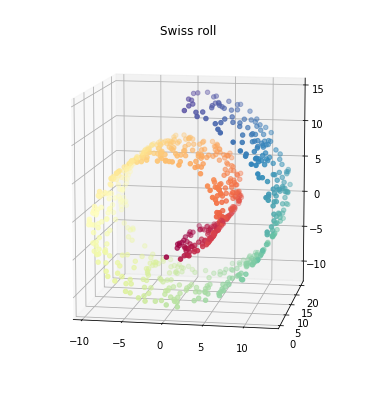

In [17]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.view_init(10, -80)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=c1, cmap=plt.cm.Spectral)
plt.title('Swiss roll')
plt.show()

In [18]:
gse = GSE(n_neighbors=k, max_iter=100, sigma=3, solver='base')
Q, H, G = gse.fit(X_train)
z = gse.transform(X_train)

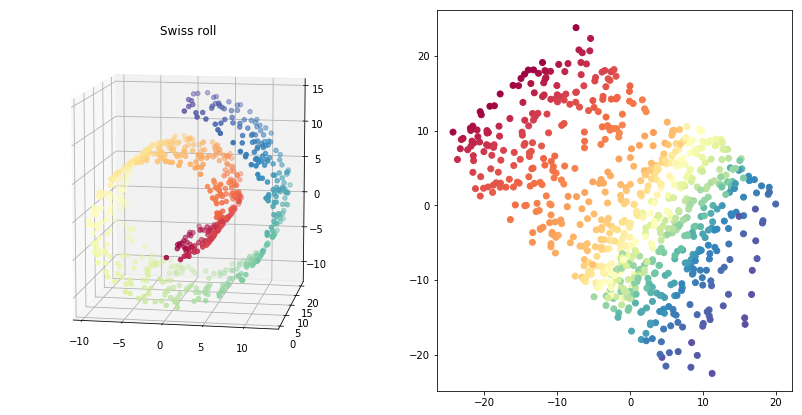

In [19]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.view_init(10, -80)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=c1, cmap=plt.cm.Spectral)
plt.title('Swiss roll')

plt.subplot(122)
plt.scatter(z[:, 0], z[:, 1], c=c1, cmap=plt.cm.Spectral)
plt.show()

In [20]:
data_to_reconstruct = np.copy(z)

In [21]:
X_rec = gse.reconstruct(data_to_reconstruct, z)

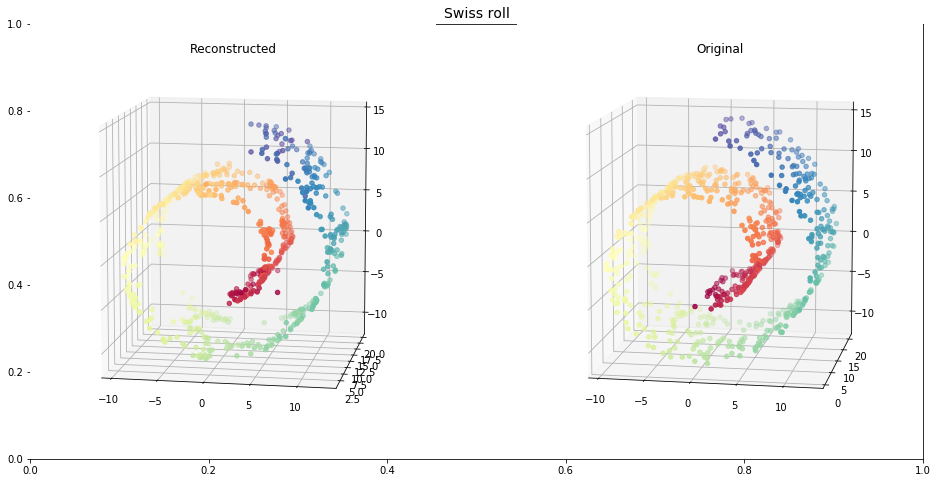

In [22]:
fig = plt.figure(figsize=(16,8))
plt.title("Swiss roll", fontsize=14)

ax = fig.add_subplot(121, projection='3d')
ax.view_init(10, -80)
ax.scatter(X_rec[:, 0], X_rec[:, 1], X_rec[:, 2], c = c1, cmap=plt.cm.Spectral)
plt.title("Reconstructed")

ax = fig.add_subplot(122, projection='3d')
ax.view_init(10, -80)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c = c1, cmap=plt.cm.Spectral)
plt.title("Original")

plt.show()

In [23]:
h, g = gse.embedding_OOS(X_test)

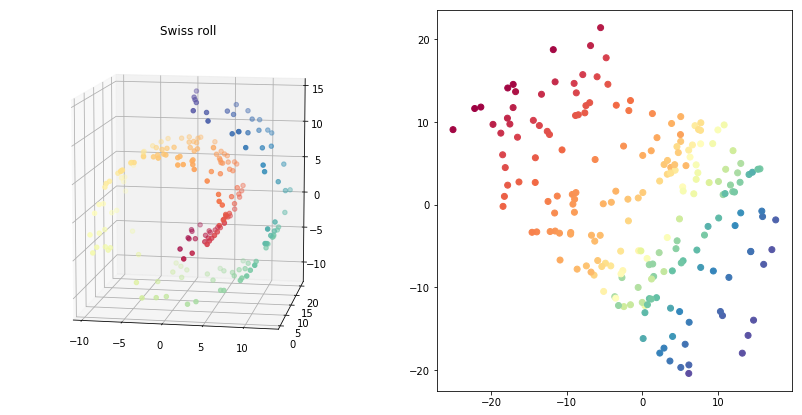

In [24]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.view_init(10, -80)
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=c2, cmap=plt.cm.Spectral)
plt.title('Swiss roll')

plt.subplot(122)
plt.scatter(h[:, 0], h[:, 1], c=c2, cmap=plt.cm.Spectral)
plt.show()

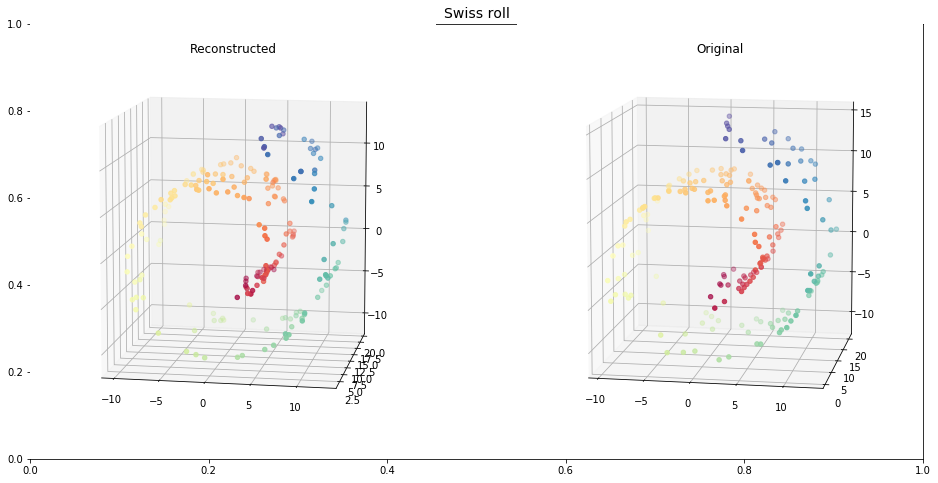

In [25]:
fig = plt.figure(figsize=(16,8))
plt.title("Swiss roll", fontsize=14)

ax = fig.add_subplot(121, projection='3d')
ax.view_init(10, -80)
ax.scatter(g[:, 0], g[:, 1], g[:, 2], c=c2, cmap=plt.cm.Spectral)
plt.title("Reconstructed")

ax = fig.add_subplot(122, projection='3d')
ax.view_init(10, -80)
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=c2, cmap=plt.cm.Spectral)
plt.title("Original")

plt.show()

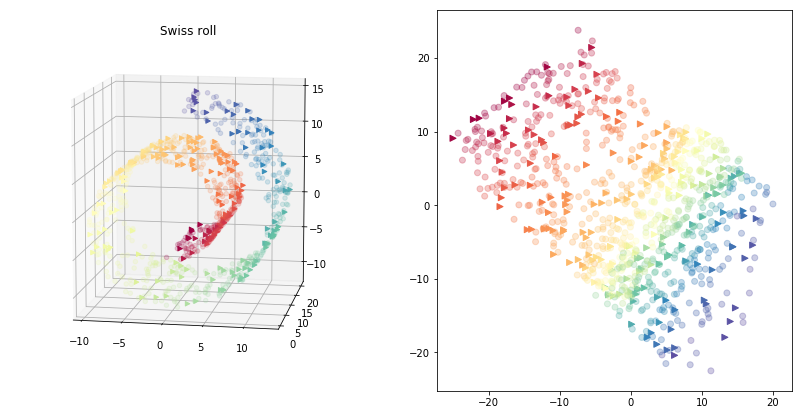

In [26]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.view_init(10, -80)
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],c=c2, cmap=plt.cm.Spectral, marker = '>', alpha = 1)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=c1, cmap=plt.cm.Spectral, alpha = 0.2)
plt.title('Swiss roll')

plt.subplot(122)
plt.scatter(h[:, 0], h[:, 1],c=c2, cmap=plt.cm.Spectral, marker = '>', alpha = 1)
plt.scatter(z[:, 0], z[:, 1], c=c1, cmap=plt.cm.Spectral, alpha = 0.3)
plt.show()

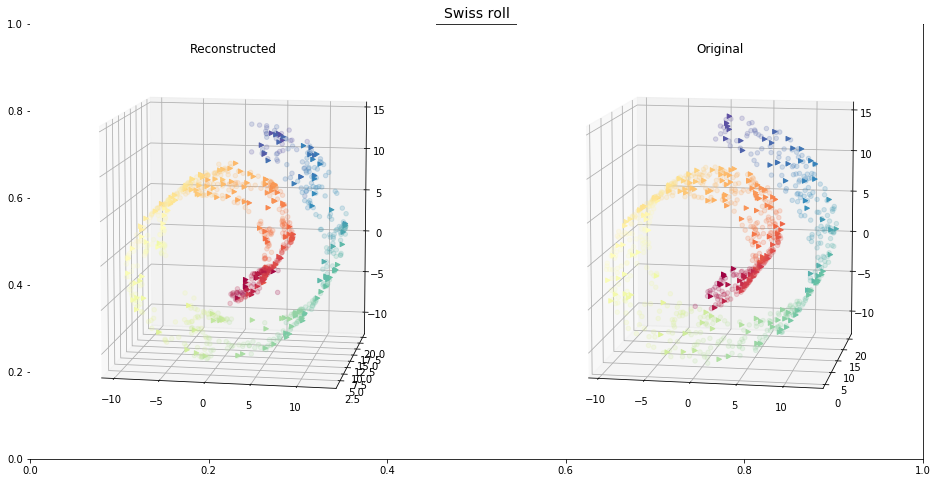

In [27]:
fig = plt.figure(figsize=(16,8))
plt.title("Swiss roll", fontsize=14)

ax = fig.add_subplot(121, projection='3d')
ax.view_init(10, -80)
ax.scatter(g[:, 0], g[:, 1], g[:, 2], c=c2, cmap=plt.cm.Spectral, marker = '>', alpha = 1)
ax.scatter(X_rec[:, 0], X_rec[:, 1], X_rec[:, 2], c=c1, cmap=plt.cm.Spectral, alpha = 0.2)
plt.title("Reconstructed")

ax = fig.add_subplot(122, projection='3d')
ax.view_init(10, -80)
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=c2, cmap=plt.cm.Spectral, marker = '>', alpha = 1)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=c1, cmap=plt.cm.Spectral, alpha = 0.2)
plt.title("Original")

plt.show()